In [ ]:

from google.colab import drive
import sys
import os

drive.mount('/content/drive')

# Personalized path to your project directory
path = '/content/drive/MyDrive/cod/LEA3_health_7' # Replace with your actual path

# Add the path to sys.path
sys.path.append(path)
os.chdir(path)

os.curdir


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'.'

In [ ]:
####instalar paquetes
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import joblib ### para cargar array

########Paquetes para NN #########
import tensorflow as tf
from sklearn import metrics ### para analizar modelo
from sklearn.metrics import roc_auc_score
import pandas as pd


import tensorflow as tf
from tensorflow.keras.utils import to_categorical  # convertir etiquetas a one-hot encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint ## guardar mejor modelo


import optuna


In [ ]:

### cargar bases_procesadas ####
X_train_cnn = joblib.load('salidas/X_train_cnn.pkl')
y_train_cnn = joblib.load('salidas/y_train_cnn.pkl')
X_test_cnn = joblib.load('salidas/X_test_cnn.pkl')
y_test_cnn = joblib.load('salidas/y_test_cnn.pkl')

In [ ]:
# Realizar codificación one-hot en las etiquetas
y_train = to_categorical(y_train_cnn, num_classes = 7)
y_test = to_categorical(y_test_cnn, num_classes = 7)

In [ ]:
# Set the CNN model
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(16,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(32, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 75, 100, 16)    │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 100, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 37, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       921,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 938,775 (3.58 MB)

 Trainable params: 938,775 (3.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['recall'])

In [ ]:
history = model.fit(
    X_train_cnn, y_train,
    epochs=10,
    validation_data=(X_test_cnn, y_test)
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 131s 512ms/step - accuracy: 0.6513 - loss: 1.1019 - val_accuracy: 0.6560 - val_loss: 0.9209
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 495ms/step - accuracy: 0.6782 - loss: 0.9040 - val_accuracy: 0.6825 - val_loss: 0.8368
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 146s 510ms/step - accuracy: 0.6980 - loss: 0.8186 - val_accuracy: 0.6930 - val_loss: 0.8148
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 509ms/step - accuracy: 0.7073 - loss: 0.7745 - val_accuracy: 0.7214 - val_loss: 0.7844
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 144s 519ms/step - accuracy: 0.7275 - loss: 0.7214 - val_accuracy: 0.7289 - val_loss: 0.7325
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 503ms/step - accuracy: 0.7569 - loss: 0.6567 - val_accuracy: 0.7224 - val_loss: 0.7426
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 141s 500ms/step - accuracy: 0.7683 - loss: 0.6215 - val_accuracy: 0.7309 - val_loss: 0.7522
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 141s 496ms/step - accuracy: 0.7797 -

In [ ]:
def objective(trial):
    K.clear_session()

    # Hiperparámetros a optimizar
    conv1_filters = trial.suggest_categorical('conv1_filters', [16, 32, 64])
    conv2_filters = trial.suggest_categorical('conv2_filters', [16, 32, 64])
    dense_units = trial.suggest_int('dense_units', 32, 128, step=32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    # Optimizador
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Modelo CNN
    model = Sequential()
    model.add(Conv2D(conv1_filters, kernel_size=(3, 3), activation='relu', padding='Same', input_shape=(75, 100, 3)))
    model.add(Conv2D(conv1_filters, kernel_size=(3, 3), activation='relu', padding='Same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(conv2_filters, (3, 3), activation='relu', padding='Same'))
    model.add(Conv2D(conv2_filters, (3, 3), activation='relu', padding='Same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Entrenamiento
    history = model.fit(
        X_train_cnn, y_train,
        validation_split=0.2,
        epochs=10,
        batch_size=trial.suggest_categorical('batch_size', [32, 64, 128]),
        verbose=0
    )

    # Retornar la métrica a optimizar (puedes cambiar a 'val_accuracy' o 'val_recall')
    return history.history['val_accuracy'][-1]

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Ajusta n_trials según el tiempo que quieras dedicar
best_params = study.best_trial.params
print("Mejores hiperparámetros:")
print(best_params)

[I 2025-06-07 05:13:36,963] A new study created in memory with name: no-name-b8774a13-6799-410d-a2e5-678481c3d927
<ipython-input-9-014a0f7544c2>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2025-06-07 05:33:38,811] Trial 0 finished with value: 0.7916406989097595 and parameters: {'conv1_filters': 16, 'conv2_filters': 16, 'dense_units': 32, 'dropout_rate': 0.4450670431002808, 'learning_rate': 0.00023493372345743518, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 0 with value: 0.7916406989097595.
[W 2025-06-07 05:36:00,299] Trial 1 failed with parameters: {'conv1_filters': 64, 'conv2_filters': 16, 'dense_units': 32, 'dropout_rate': 0.4054254237887609, 'learning_rate': 0.0014297418882331294, 'optimizer': 'rmsprop', 'batch_size': 128} because of the 

KeyboardInterrupt: 

In [ ]:
history = model.fit(
    X_train_cnn, y_train,
    epochs=10,
    batch_size=best_params['batch_size'],
    validation_data=(X_test_cnn, y_test)
)

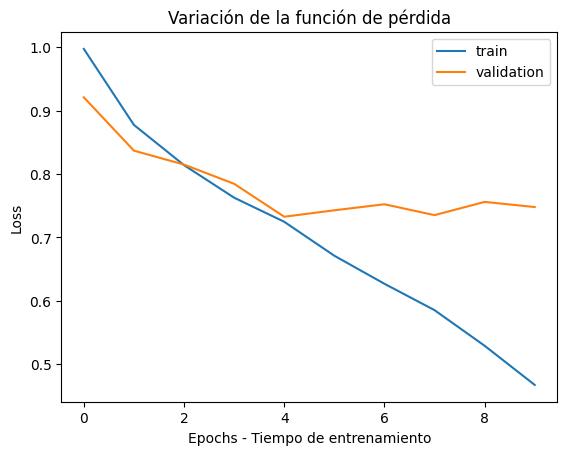

In [ ]:
import matplotlib.pyplot as plt
# Visualización de las curvas de error

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Variación de la función de pérdida')
plt.xlabel('Epochs - Tiempo de entrenamiento')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.show()


In [ ]:

# Visualización de las curvas de Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Variación del Accuracy')
plt.xlabel('Epochs - Tiempo de entrenamiento')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()
